In [51]:
# 기본
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# 프로젝트
from dataset.dataset_config import edge_index, edge_attr, week_steps, edge_adj_mat, C_origin
from dataset.dataset_config import converted_nodes, converted_edges, river_info # only for visualization
from dataset.traffic_dataset import TrafficDataset
from dataset.traffic_dataset import EDGE_INDEX, EDGE_ATTR
from utils.Trainer import Trainer
from utils.calculate_performance_index import calculate_performance_index
from utils.visualization import plot_mape_violin, visualize_predictions, add_tod_dow, plot_city_edge_mape
from models.STLinear_biased_models import STLinear_HopBiased, compute_spe_torch


In [52]:
# MAPE
class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


In [53]:
# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 64
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [54]:
# 공통 파라미터 및 모델 목록 정의
WINDOW       = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS     = [2]                  # 시각화할 edge index 리스트
T_TOTAL      = data.shape[0]        # 전체 타임스텝 수
SAVE_DIR     = "./checkpoints"      
os.makedirs(SAVE_DIR, exist_ok=True)

models = {
    "STLinear_HopBiased": STLinear_HopBiased
}

In [55]:
EDGE_INDEX = EDGE_INDEX.to(DEVICE)
EDGE_ATTR = EDGE_ATTR.to(DEVICE)

# ─────────────────────────────────────────────────────────
# 4) 저장된 체크포인트 로드
# ─────────────────────────────────────────────────────────

for name, ModelClass in models.items():
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    kwargs = dict(
    num_nodes            = 50,    # 엣지 수
    kernel_size          = 33,    # 시계열 분해 커널 크기
    in_steps             = 12,    # 입력 시점 길이
    out_steps            = 3,     # 예측 시점 길이
    steps_per_day        = 480,   # 하루 스텝 수
    input_dim            = 3,     # volume/density/flow
    output_dim           = 3,     # 예측 채널
    input_embedding_dim  = 24,    # traffic → 24차원 임베딩
    tod_embedding_dim    = 24,    # time-of-day 임베딩
    dow_embedding_dim    = 24,    # day-of-week 임베딩
    spatial_embedding_dim= 0,     # 원본에서는 사용 안 함
    adaptive_embedding_dim= 80,   # adaptive embedding 크기
    feed_forward_dim     = 256,   # FFN hidden dim
    num_heads            = 2,     # max_hop + 1 = 2, 순수 어텐션 + 홉 bias
    num_layers           = 6,     # 블록 반복 횟수
    dropout              = 0.14,  # 드롭아웃 비율
    use_mixed_proj       = True   # 마지막 예측용 Projection
    )
    
    model = ModelClass(**kwargs)
    model.to(DEVICE)

    ckpt_path = os.path.join(SAVE_DIR, f"{name}.pth")
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE, weights_only=True))
    model = model.to(DEVICE)


--- Visualizing STLinear_HopBiased ---


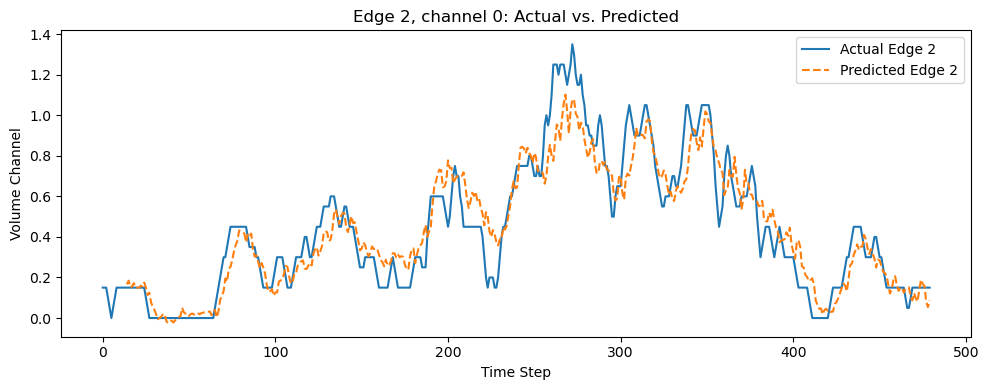

In [56]:
print(f"\n--- Visualizing {name} ---")
EDGE_IDS = [2]
expanded_data = add_tod_dow(data, week_steps=week_steps, C_origin=C_origin)
visualize_predictions(model, expanded_data, EDGE_IDS, DEVICE, EDGE_INDEX, EDGE_ATTR, interval=(480*5,480*6), channel=0)

In [57]:
from dataset.dataset_config import node_idx_map
print(node_idx_map)

{0: (0, 7), 1: (7, 0), 2: (1, 12), 3: (12, 1), 4: (2, 6), 5: (6, 2), 6: (2, 13), 7: (13, 2), 8: (2, 17), 9: (17, 2), 10: (3, 5), 11: (5, 3), 12: (4, 6), 13: (6, 4), 14: (4, 7), 15: (7, 4), 16: (4, 13), 17: (13, 4), 18: (5, 6), 19: (6, 5), 20: (5, 9), 21: (9, 5), 22: (5, 15), 23: (15, 5), 24: (5, 17), 25: (17, 5), 26: (6, 15), 27: (15, 6), 28: (6, 18), 29: (18, 6), 30: (7, 12), 31: (12, 7), 32: (8, 15), 33: (15, 8), 34: (10, 16), 35: (16, 10), 36: (10, 17), 37: (17, 10), 38: (11, 19), 39: (19, 11), 40: (13, 14), 41: (14, 13), 42: (14, 17), 43: (17, 14), 44: (14, 18), 45: (18, 14), 46: (14, 19), 47: (19, 14), 48: (15, 17), 49: (17, 15)}


In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from math import log
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

# Load traffic dataset: shape (time_steps, edges, channels)
traffic_data = np.load('dataset/traffic_dataset_13_smoothen.npy')

# ── Utilities ────────────────────────────────────────────────────────────

def entropy_by_head(attn):
    """
    Compute normalized entropy for each attention head.
    
    Args:
        attn (torch.Tensor): Attention matrix of shape (heads, edges, edges).
        
    Returns:
        torch.Tensor: Entropy value per head, shape (heads,).
    """
    H, E, _ = attn.shape
    # clamp to avoid log(0), compute entropy, normalize by log(E)
    ent = (-(attn.clamp_min(1e-9) * attn.clamp_min(1e-9).log())
            .sum(-1).sum(-1) / log(E))
    return ent

def plot_topk_heat(attn_map, layer, head, top_k=3):
    """
    Plot a heatmap showing the top-k attention weights per query edge.
    
    Args:
        attn_map (ndarray): 2D attention map of shape (edges, edges).
        layer (int): Layer index.
        head (int): Head index.
        top_k (int): Number of top edges to highlight per row.
        
    Returns:
        ndarray: Masked attention map with only top-k values.
    """
    E = attn_map.shape[0]
    topk = np.zeros_like(attn_map)
    for i in range(E):
        indices = np.argsort(attn_map[i])[::-1][:top_k]
        topk[i, indices] = attn_map[i, indices]
    plt.figure(figsize=(5, 4))
    sns.heatmap(topk, cmap='Blues', cbar_kws={'label': 'Attention Weight'})
    plt.title(f"Layer {layer}, Head {head}, Top-{top_k} Attention")
    plt.xlabel("Key Edge")
    plt.ylabel("Query Edge")
    plt.tight_layout()
    plt.show()
    return topk

def plot_timeseries(edge_id, global_time, window=48, highlight=12, channel=0):
    """
    Plot the time series for a specific edge around a given global time index.
    
    Args:
        edge_id (int): Edge index to plot.
        global_time (int): Center time index.
        window (int): Number of time steps before and after to include.
        highlight (int): Range around the center to shade.
        channel (int): Data channel index.
    """
    T = traffic_data.shape[0]
    start = max(0, global_time - window)
    end = min(T, global_time + window + 1)
    time_indices = np.arange(start, end)
    plt.figure(figsize=(10, 4))
    plt.plot(time_indices, traffic_data[start:end, edge_id, channel], linewidth=1.5)
    # highlight the central region
    plt.axvspan(max(start, global_time - highlight),
                min(end, global_time + highlight),
                alpha=0.12)
    plt.title(f"Edge {edge_id} | Time Index {global_time} ±{window}")
    plt.xlabel("Time Index")
    plt.ylabel("Traffic Volume")
    plt.tight_layout()
    plt.show()

# ── Core Exploration Function ────────────────────────────────────────────

def explore_low_entropy_heads(model, validation_dataset, device,
                              global_time, time_step=0,
                              top_k_heads=5,    # number of lowest-entropy heads to show
                              heatmap_k=3):     # top-k edges per row in heatmap
    """
    Identify and analyze attention heads with the lowest entropy.
    
    Args:
        model: Graph-based attention model with `return_attn` support.
        validation_dataset: Dataset object with `starts` attribute.
        device: torch device (cpu or cuda).
        global_time (int): Global time index to analyze.
        time_step (int): Time step within the sequence for attention.
        top_k_heads (int): Number of heads with lowest entropy to list.
        heatmap_k (int): Number of top edges to visualize per query edge.
    """
    # Map global time to dataset index
    time_to_index = {t0: idx for idx, t0 in enumerate(validation_dataset.starts)}
    subset = Subset(validation_dataset, [time_to_index[global_time]])
    loader = DataLoader(subset, batch_size=1,
                        pin_memory=(device.type == 'cuda'))
    batch = next(iter(loader)).to(device)
    inputs = batch.x.unsqueeze(0) if batch.x.dim() == 3 else batch.x  # shape (1, T, E, C)

    # Forward pass to retrieve all attention maps
    with torch.no_grad():
        _, attention_list = model(
            inputs,
            getattr(batch, 'edge_index', None),
            getattr(batch, 'edge_attr', None),
            return_attn=True
        )  # returns list over layers, each of shape (B*T, H, E, E)

    B, T = inputs.size(0), inputs.size(1)
    candidates = []  # list of tuples (entropy, layer, head, attn_map)

    # Compute entropy for each head in each layer
    for layer_idx, raw_attn in enumerate(attention_list):
        attn = raw_attn.view(B, T, *raw_attn.shape[1:])[0, time_step]  # shape (H, E, E)
        entropies = entropy_by_head(attn)  # shape (H,)
        for head_idx, ent in enumerate(entropies):
            candidates.append((ent.item(), layer_idx, head_idx, attn[head_idx]))

    # Sort by entropy and select top-k lowest
    candidates.sort(key=lambda x: x[0])
    top_candidates = candidates[:top_k_heads]

    print(f"\nGlobal Time Index: {global_time}, Time Step: {time_step}")
    print("Heads with the Lowest Entropy:")
    for rank, (entropy_val, layer_idx, head_idx, _) in enumerate(top_candidates, start=1):
        print(f"  {rank}. Layer {layer_idx} | Head {head_idx} | Entropy = {entropy_val:.4f}")

    selection = int(input("\nEnter the rank number to analyze ▶ ")) - 1
    entropy_val, selected_layer, selected_head, selected_attn = top_candidates[selection]
    print(f"\nYou Selected → Layer {selected_layer}, Head {selected_head} (Entropy = {entropy_val:.4f})")

    # Display heatmap and list of top edges
    topk_mask = plot_topk_heat(selected_attn.cpu().numpy(),
                               selected_layer, selected_head, heatmap_k)
    src_indices, dst_indices = np.nonzero(topk_mask)
    edge_pairs = list(zip(src_indices, dst_indices))
    print(f"\nList of Candidate Edges (row, column) for Top-{heatmap_k}:")
    for idx, (src, dst) in enumerate(edge_pairs):
        print(f"  {idx}: ({src}, {dst})")

    edge_choice = int(input("\nSelect an edge index to view its time series ▶ "))
    edge_id = edge_pairs[edge_choice][1]  # use the key edge index
    print(f"\nTime Series for Edge {edge_id}:")
    plot_timeseries(edge_id, global_time)



Global Time Index: 3421, Time Step: 0
Heads with the Lowest Entropy:
  1. Layer 4 | Head 1 | Entropy = 43.2010
  2. Layer 3 | Head 1 | Entropy = 44.2093
  3. Layer 4 | Head 0 | Entropy = 45.0018
  4. Layer 1 | Head 0 | Entropy = 46.5448
  5. Layer 3 | Head 0 | Entropy = 46.7220

You Selected → Layer 4, Head 1 (Entropy = 43.2010)


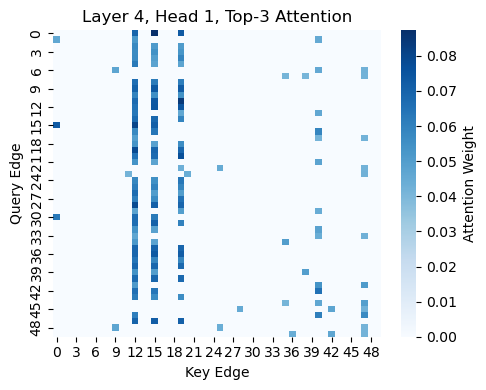


List of Candidate Edges (row, column) for Top-3:
  0: (0, 12)
  1: (0, 15)
  2: (0, 19)
  3: (1, 0)
  4: (1, 12)
  5: (1, 40)
  6: (2, 12)
  7: (2, 15)
  8: (2, 19)
  9: (3, 12)
  10: (3, 15)
  11: (3, 19)
  12: (4, 12)
  13: (4, 15)
  14: (4, 19)
  15: (5, 12)
  16: (5, 15)
  17: (5, 19)
  18: (6, 9)
  19: (6, 40)
  20: (6, 47)
  21: (7, 35)
  22: (7, 38)
  23: (7, 47)
  24: (8, 12)
  25: (8, 15)
  26: (8, 19)
  27: (9, 12)
  28: (9, 15)
  29: (9, 19)
  30: (10, 12)
  31: (10, 15)
  32: (10, 19)
  33: (11, 12)
  34: (11, 15)
  35: (11, 19)
  36: (12, 12)
  37: (12, 15)
  38: (12, 19)
  39: (13, 12)
  40: (13, 19)
  41: (13, 40)
  42: (14, 12)
  43: (14, 15)
  44: (14, 19)
  45: (15, 0)
  46: (15, 12)
  47: (15, 15)
  48: (16, 12)
  49: (16, 15)
  50: (16, 40)
  51: (17, 12)
  52: (17, 40)
  53: (17, 47)
  54: (18, 12)
  55: (18, 15)
  56: (18, 19)
  57: (19, 12)
  58: (19, 15)
  59: (19, 19)
  60: (20, 12)
  61: (20, 15)
  62: (20, 19)
  63: (21, 12)
  64: (21, 15)
  65: (21, 40)
  6

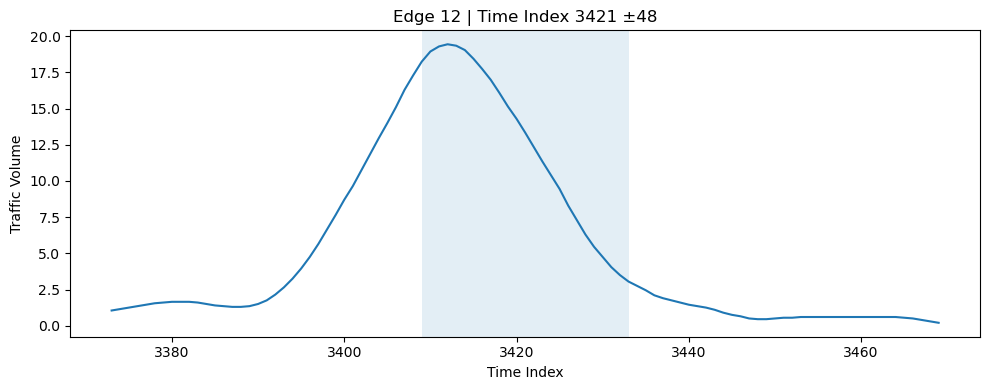

In [64]:
# --------------- 사용 예시 --------------- #
explore_low_entropy_heads(
    model      = model,
    validation_dataset = valid_ds,
    device     = torch.device(DEVICE),
    global_time= valid_ds.starts[50],
    time_step  = 0,
    top_k_heads= 5)
